In [1]:
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

--2020-04-29 20:53:24--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
正在解析主机 files.grouplens.org (files.grouplens.org)... 128.101.65.152
正在连接 files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... 已连接。
已发出 HTTP 请求，正在等待回应... 200 OK
长度：978202 (955K) [application/zip]
正在保存至: “ml-latest-small.zip”

ml-latest-small.zip 100%[===================>] 955.28K   242KB/s  用时 4.0s      

2020-04-29 20:53:31 (242 KB/s) - 已保存 “ml-latest-small.zip” [978202/978202])



In [3]:
!unzip ml-latest-small.zip

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [2]:
!pip install surprise

     |████████████████████████████████| 6.4 MB 27 kB/s eta 0:00:01
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.0-cp38-cp38-macosx_10_9_x86_64.whl size=834796 sha256=5ba82891867c85cddd4fd72c1a639da06d073f2b32ec7d2a5925491b1c67eea7
  Stored in directory: /Users/yhltc/Library/Caches/pip/wheels/1f/ef/98/0e156baf64947bed20b6f3313cb2b4b0b47c36374293e506e2
Successfully built scikit-surprise


In [4]:
import pandas as pd
import numpy as np
from surprise.prediction_algorithms.matrix_factorization import NMF
filename = 'ml-latest-small/ratings.csv'
# load data
data = pd.read_csv(filename)
data.shape

(100836, 4)

In [5]:
R = data.pivot_table(index='userId', columns='movieId', 
                       values='rating').values
R
R.shape

(610, 9724)

In [6]:
#稀疏度
total_possible=R.shape[0]*R.shape[1]
total_available=data.shape[0]
print(total_available/total_possible)

0.016999683055613623


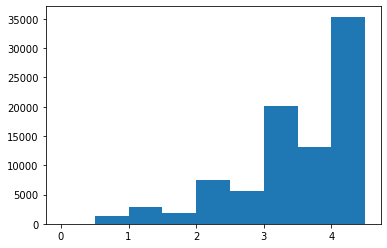

In [7]:
#分数分布
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

r=data.rating.tolist()
x = np.arange(0, 5, 0.5)
plt.hist(r, bins=x)
plt.show()

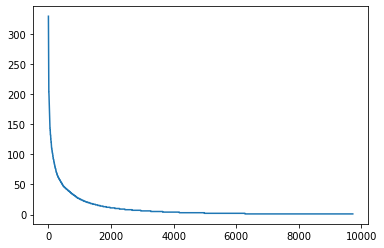

In [8]:
#被打分的电影有几个人打分
ratings_movie=[]
for i in range(R.shape[1]):
  r=R.shape[0]-np.count_nonzero(np.isnan(R[:,i]))
  ratings_movie.append(r)
ratings_movie=np.sort(ratings_movie)
plt.plot(ratings_movie[::-1])

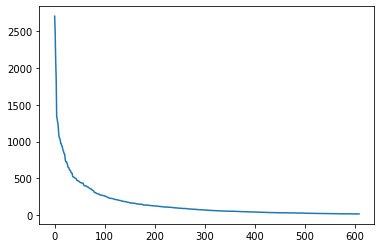

In [9]:
#用户打分数
ratings_users=[]
for i in range(R.shape[0]):
  r=R.shape[1]-np.count_nonzero(np.isnan(R[i]))
  ratings_users.append(r)
ratings_users=np.sort(ratings_users)
plt.plot(ratings_users[::-1])

<function matplotlib.pyplot.show(*args, **kw)>

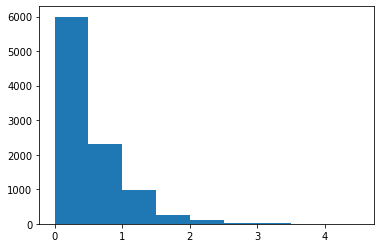

In [10]:
#电影方差
movie_var = np.nanvar(R, axis=0)
x = np.arange(0, 5, 0.5)
plt.hist(movie_var, bins=x)
plt.show

In [18]:
import surprise
from surprise import KNNWithMeans
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import Reader

filename = 'ml-latest-small/ratings.csv'
reader = Reader(line_format='user item rating timestamp', sep=',',skip_lines=1)
data = Dataset.load_from_file(filename,reader=reader)

sim_options = {'name': 'pearson'}
RMSE = []
MAE= []

for k in range(2,30):
  knn = cross_validate(KNNWithMeans(k=k, sim_options=sim_options), data, measures=['rmse', 'mae'], cv=10)
  RMSE.append(np.mean(knn['test_rmse']))
  MAE.append(np.mean(knn['test_mae']))


Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

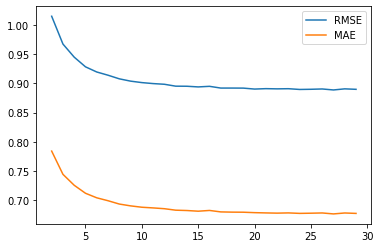

In [20]:
plt.plot(range(2,30),RMSE,label='RMSE')
plt.plot(range(2,30),MAE,label='MAE')
plt.legend()

In [0]:
#推荐列表
from surprise import Reader
from surprise import KNNWithMeans

k=16
sim_options = {'name': 'pearson'}
threshold = 3
#data alreay get above
data = Dataset.load_from_file(filename,reader=reader)
kf = KFold(n_splits=10)
knn = KNNWithMeans(k=k, sim_options=sim_options)
averagePrecisions=[]
averageRecalls=[]

for trainset, testset in kf.split(data):
    knn.fit(trainset)
    predictions = knn.test(testset)
    recommendlist={}
    for prediction in predictions:
      if recommendlist.get(prediction[0]) is None:
        recommendlist[prediction[0]] = []
      recommendlist[prediction[0]].append((prediction[1], prediction[2]))
    groudtruth={}
    ratelist={}
    for data in testset:
      if ratelist.get(data[0]) is None:
        ratelist[data[0]] = []
      ratelist[data[0]].append(data[1])
      if groudtruth.get(data[0]) is None and data[2]>=threshold:
        groudtruth[data[0]] = [] 
      if data[2]>=threshold:
        groudtruth[data[0]].append(data[1])
    for key in recommendlist:
      recommendlist[key] = sorted(recommendlist[key], key = lambda x:x[1], reverse=True)
      #print(recommendlist[key])
    for t in range(1,26):
      Precision=0
      Recall=0
      sum=0
      for key in ratelist:        
        if len(ratelist[key])>t and groudtruth.get(key) and len(groudtruth[key])>0:
          sum+=1
          #list = recommendlist[key]
          intersection=0
          for r in recommendlist[key][0:t]:
            if r[0] in groudtruth[key]:
              intersection+=1
          Precision+=intersection/len(recommendlist[key][0:t])
          Recall+=intersection/len(groudtruth[key])
      Precision=Precision/sum
      Recall=Recall/sum
      averagePrecisions.append(Precision)
      averageRecalls.append(Recall)
      print(averagePrecisions,averageRecalls)

Computing the pearson similarity matrix...
Done computing similarity matrix.
[1.0] [0.20566064075800436]
[1.0, 0.9960629921259843] [0.20566064075800436, 0.3156297591515058]
[1.0, 0.9960629921259843, 0.991941391941392] [0.20566064075800436, 0.3156297591515058, 0.3868348933482348]
[1.0, 0.9960629921259843, 0.991941391941392, 0.9880952380952381] [0.20566064075800436, 0.3156297591515058, 0.3868348933482348, 0.4202502137792719]
[1.0, 0.9960629921259843, 0.991941391941392, 0.9880952380952381, 0.9877777777777782] [0.20566064075800436, 0.3156297591515058, 0.3868348933482348, 0.4202502137792719, 0.45513831700669927]
[1.0, 0.9960629921259843, 0.991941391941392, 0.9880952380952381, 0.9877777777777782, 0.9894179894179893] [0.20566064075800436, 0.3156297591515058, 0.3868348933482348, 0.4202502137792719, 0.45513831700669927, 0.4635547712599813]
[1.0, 0.9960629921259843, 0.991941391941392, 0.9880952380952381, 0.9877777777777782, 0.9894179894179893, 0.9919517102615695] [0.20566064075800436, 0.31562975

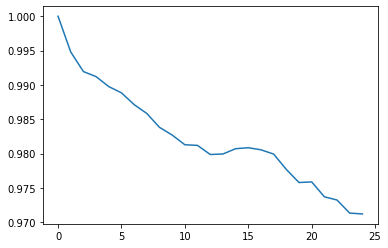

In [0]:
plt.plot(Precisionsresult)

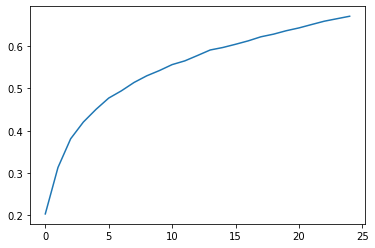

In [0]:
plt.plot(Recallresult)

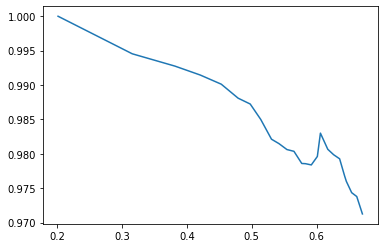

In [0]:
plt.plot(Recallresult,Precisionsresult)

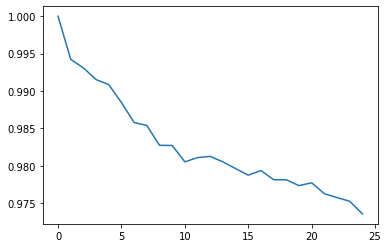

In [0]:
plt.plot(svd_Precisionsresult)

In [0]:
#Question 12,13,14:
from surprise import accuracy
from surprise.model_selection import KFold

ratings = {}
for row in data.raw_ratings:
    if row[1] not in ratings:
        ratings[row[1]] = []
    ratings[row[1]].append(row[2])

var = {}
for key in ratings:
    var[key] = np.var(ratings[key])

rmse_pop=[]

for k in range(2,max_k,2):
   knn = KNNWithMeans(k=k, sim_options=sim_options)
   rmse_pop_temp=0
   for trainset,testset in KFold(n_splits=10).split(data):
     knn.fit(trainset)
     trimset_pop=[x for x in testset if len(ratings[x[1]])>2]
     trimset_unpop=[x for x in testset if len(ratings[x[1]])<=2]
     trimset_var=[x for x in testset if len(ratings[x[1]])>=5 and var[x[1]]>=2]
     pre_pop=knn.test(trimset_pop)
     rmse_pop_temp+=accuracy.rmse(pre_pop)
     pre_unpop=knn.test(trimset_unpop)
     rmse_unpop_temp+=accuracy.rmse(pre_unpop)
     pre_var=knn.test(trimset_var)
     rmse_var_temp+=accuracy.rmse(pre_var)
   rmse_pop.append(rmse_pop_temp/10)
   rmse_unpop.append(rmse_unpop_temp/10)
   rmse_var.append(rmse_var_temp/10)

plt.plot(range(2,max_k,2),rmse_pop,label='Popular movie')
plt.plot(range(2,max_k,2),rmse_unpop,label='Unpopular movie')
plt.plot(range(2,max_k,2),rmse_var,label='High variance movie')
plt.legend()

In [0]:
# Question 15 Plot the ROC curves
import surprise
from surprise import KNNWithMeans
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import Reader
from sklearn import metrics
from surprise.model_selection import train_test_split

#k=16
thresholds=[2.5,3,3.5,4.0]
knn = surprise.prediction_algorithms.knns.KNNWithMeans(k=16, sim_options=sim_options)
trainset, testset = train_test_split(data, test_size=.1)
knn.fit(trainset)
prediction = knn.test(testset)
print(prediction)
for threshold in thresholds:
  label=[]
  pred=[]
  for _,_,r_real,r_pred,_ in prediction:
    pred.append(r_pred)
    if r_real >= threshold:
        label.append(1)
    else:
        label.append(0)    
  fpr, tpr, _ = metrics.roc_curve(label, pred, pos_label=1)
  plt.plot(fpr, tpr, label='AUC value = %0.3f' % metrics.roc_auc_score(label, pred))
  plt.legend()
  plt.show() 

k: 2; RMSE: [1.14539711 1.14082203 1.13352061 1.15654719 1.1362921  1.14733306
 1.13397285 1.15239936 1.14681013 1.13642494]; MAE: [0.96367453 0.95872416 0.9537766  0.97386507 0.95811498 0.96538418
 0.95023968 0.96917327 0.96539463 0.95669026]
k: 4; RMSE: [1.03939201 1.03833699 1.02897371 1.03950709 1.04290475 1.03765999
 1.04721704 1.03644845 1.03773945 1.03916563]; MAE: [0.84894438 0.84743862 0.84407092 0.84879064 0.85063062 0.84872578
 0.85618308 0.84791775 0.85108432 0.84852534]
k: 6; RMSE: [0.98346495 0.97649197 0.98136586 0.97316341 0.97673436 0.98253016
 0.9813013  0.98772588 0.99002515 0.98003216]; MAE: [0.78765454 0.78262761 0.78420545 0.77952224 0.78243308 0.78970404
 0.78342942 0.79173863 0.79300338 0.78485147]
k: 8; RMSE: [0.95465439 0.94799026 0.94932525 0.95061218 0.94778784 0.94301403
 0.95186948 0.95747863 0.95525828 0.94173095]; MAE: [0.75108138 0.74903726 0.74983613 0.7444682  0.74603343 0.74147375
 0.7527844  0.75638771 0.75188876 0.74589374]
k: 10; RMSE: [0.94161441

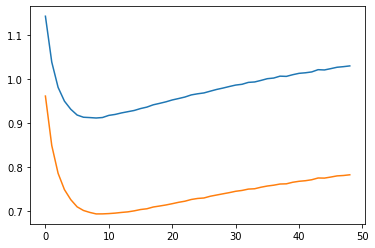

In [0]:
# Question 17
from surprise.prediction_algorithms.matrix_factorization import NMF
RMSE = []
MAE= []

for k in range(2,100,2):
  nmf = NMF(n_factors=k)
  nmf_result = cross_validate(nmf, data, measures=['rmse', 'mae'], cv=10)
  RMSE.append(np.mean(nmf_result['test_rmse']))
  MAE.append(np.mean(nmf_result['test_mae']))
  print("k: {}; RMSE: {}; MAE: {}".format(k, nmf_result['test_rmse'], nmf_result['test_mae']))
plt.plot(RMSE)
plt.plot(MAE)

In [0]:
print("min k for RMSE: {}, MAE: {}".format(np.argmin(RMSE), np.argmin(MAE)))
print("min RMSE: {}, MAE: {}".format(min(RMSE), min(MAE)))

min k for RMSE: 8, MAE: 8
min RMSE: 0.9116706117188439, MAE: 0.6936689098644417


In [0]:
rmse_pop=[]
rmse_unpop=[]
rmse_var=[]
max_k=100
for k in range(2,max_k,2):
   nmf = NMF(n_factors=k)
   rmse_pop_temp=0
   rmse_unpop_temp=0
   rmse_var_temp=0
   for trainset,testset in KFold(n_splits=10).split(data):
     nmf.fit(trainset)
     trimset_pop=[x for x in testset if len(ratings[x[1]])>2]
     trimset_unpop=[x for x in testset if len(ratings[x[1]])<=2]
     trimset_var=[x for x in testset if len(ratings[x[1]])>=5 and var[x[1]]>=2]
     pre_pop=nmf.test(trimset_pop)
     rmse_pop_temp+=accuracy.rmse(pre_pop)
     pre_unpop=nmf.test(trimset_unpop)
     rmse_unpop_temp+=accuracy.rmse(pre_unpop)
     pre_var=nmf.test(trimset_var)
     rmse_var_temp+=accuracy.rmse(pre_var)
   rmse_pop.append(rmse_pop_temp/10)
   rmse_unpop.append(rmse_unpop_temp/10)
   rmse_var.append(rmse_var_temp/10)

plt.plot(range(2,max_k,2),rmse_pop,label='Popular movie')
plt.plot(range(2,max_k,2),rmse_unpop,label='Unpopular movie')
plt.plot(range(2,max_k,2),rmse_var,label='High variance movie')
plt.legend()

print("min avg for popular movie : {}".format(min(rmse_pop)))
print("min avg for unpopular movie : {}".format(min(rmse_unpop)))
print("min avg for high variance movie : {}".format(min(rmse_vae)))

RMSE: 1.1230
RMSE: 1.2535
RMSE: 2.2441
RMSE: 1.1324
RMSE: 1.1384
RMSE: 1.5925
RMSE: 1.1247
RMSE: 1.1745
RMSE: 1.7520
RMSE: 1.1469
RMSE: 1.2281
RMSE: 1.6513
RMSE: 1.1429
RMSE: 1.2031
RMSE: 2.0846
RMSE: 1.1403
RMSE: 1.2715
RMSE: 1.9756
RMSE: 1.1325
RMSE: 1.2365
RMSE: 1.4125
RMSE: 1.1409
RMSE: 1.2901
RMSE: 1.3697
RMSE: 1.1466
RMSE: 1.2456
RMSE: 1.8656
RMSE: 1.1430
RMSE: 1.1833
RMSE: 1.7889
RMSE: 1.0258
RMSE: 1.1642
RMSE: 1.8305
RMSE: 1.0155
RMSE: 1.1682
RMSE: 2.0091
RMSE: 1.0378
RMSE: 1.2435
RMSE: 1.9904
RMSE: 1.0403
RMSE: 1.2728
RMSE: 1.8672
RMSE: 1.0334
RMSE: 1.2118
RMSE: 1.2878
RMSE: 1.0257
RMSE: 1.2214
RMSE: 1.7792
RMSE: 1.0188
RMSE: 1.1996
RMSE: 1.4152
RMSE: 1.0327
RMSE: 1.1917
RMSE: 1.6729
RMSE: 1.0270
RMSE: 1.2013
RMSE: 1.7094
RMSE: 1.0265
RMSE: 1.2493
RMSE: 1.9138
RMSE: 0.9739
RMSE: 1.2205
RMSE: 1.4193
RMSE: 0.9729
RMSE: 1.1904
RMSE: 1.5593
RMSE: 0.9695
RMSE: 1.1990
RMSE: 1.6884
RMSE: 0.9655
RMSE: 1.1914
RMSE: 1.7671
RMSE: 0.9785
RMSE: 1.2416
RMSE: 1.6316
RMSE: 0.9772
RMSE: 1.1982

In [0]:
thresholds=[2.5,3,3.5,4.0]
nmf = NMF(n_factors=8)
trainset, testset = train_test_split(data, test_size=.1)
nmf.fit(trainset)
prediction = nmf.test(testset)
print(prediction)
for threshold in thresholds:
  label=[]
  pred=[]
  for _,_,r_real,r_pred,_ in prediction:
    pred.append(r_pred)
    if r_real >= threshold:
        label.append(1)
    else:
        label.append(0)    
  fpr, tpr, _ = metrics.roc_curve(label, pred, pos_label=1)
  plt.plot(fpr, tpr, label='AUC value = %0.3f' % metrics.roc_auc_score(label, pred))
  plt.legend()
  plt.show() 

In [0]:
#Question 23
movie_dataframe = pd.read_csv('ml-latest-small/movies.csv')
id_to_genres = {}
movieId_l, movie_genres = movie_dataframe.movieId.tolist(), movie_dataframe.genres.tolist()
for i, genre in zip(movieId_l, movie_genres):
  id_to_genres[i] = genre

nmf = NMF(n_factors=20)
train_data = data.build_full_trainset()
nmf.fit(train_data)

movie_ids = [[] for _ in range(20)]
for i in range(20):
  f = nmf.qi[:,i]
  sorted_factors = sorted([[j, vec] for j, vec in enumerate(f)], key=lambda x:x[1], reverse=True)
  for k in range(10):
    movie_ids[i].append(sorted_factors[k][0])

genres = [[id_to_genres[int(train_data.to_raw_iid(movie_ids[i][j]))] for j in range(10)] for i in range(20)]
for i in range(20):
  print('column {} :'.format(i+1))
  for l in genres[i]:
    print(l, end=', ')
  print()

column 1 :
Drama|Mystery, Adventure|Animation|Children, Comedy|Drama|Romance, Children|Sci-Fi, Comedy|Drama, Drama, Comedy|Drama, Drama|Fantasy|Sci-Fi, Drama|Musical, Comedy|Drama, 
column 2 :
Action|Crime|Drama|Thriller, Crime|Drama|Thriller, Crime|Drama|Thriller, Comedy|Romance, Comedy, Drama|Romance, Documentary, Action|Adventure|Animation|Sci-Fi, Drama|Mystery|Thriller, Children|Drama|Fantasy|Mystery|Thriller, 
column 3 :
Action|Adventure|Comedy|Fantasy, Crime|Horror|Mystery, Children|Comedy|Romance, Adventure|Comedy|Sci-Fi, Drama|Horror|Thriller, Comedy, Drama|Sci-Fi|Thriller, Action|Crime|Drama|Thriller, Crime|Drama, Comedy|Drama, 
column 4 :
Action|Comedy|Western, Action|Comedy|Crime, Comedy, Comedy|Drama|Romance, Comedy, Adventure|Animation|Children|Comedy|Fantasy|Sci-Fi, Comedy, Comedy|Romance, Adventure|Comedy|Fantasy, Comedy|Mystery, 
column 5 :
Film-Noir|Horror|Mystery|Thriller, Comedy|Drama, Animation|Comedy|Drama|Fantasy|Sci-Fi, Children|Comedy|Drama, Comedy|Drama, Action

In [0]:
# Question 17
from surprise.prediction_algorithms.matrix_factorization import SVD
RMSE = []
MAE= []

for k in range(2,100,2):
  svd = SVD(n_factors=k, biased=True)
  svd_result = cross_validate(svd, data, measures=['rmse', 'mae'], cv=10)
  RMSE.append(np.mean(svd_result['test_rmse']))
  MAE.append(np.mean(svd_result['test_mae']))
  print("k: {}; RMSE: {}; MAE: {}".format(k, RMSE, MAE))
plt.plot(RMSE)
plt.plot(MAE)

AttributeError: ignored

In [0]:
rmse_pop=[]
rmse_unpop=[]
rmse_var=[]
max_k=100
for k in range(2,max_k,2):
   svd = SVD(n_factors=k, biased=True)
   rmse_pop_temp=0
   rmse_unpop_temp=0
   rmse_var_temp=0
   for trainset,testset in KFold(n_splits=10).split(data):
     svd.fit(trainset)
     trimset_pop=[x for x in testset if len(ratings[x[1]])>2]
     trimset_unpop=[x for x in testset if len(ratings[x[1]])<=2]
     trimset_var=[x for x in testset if len(ratings[x[1]])>=5 and var[x[1]]>=2]
     pre_pop=svd.test(trimset_pop)
     rmse_pop_temp+=accuracy.rmse(pre_pop)
     pre_unpop=svd.test(trimset_unpop)
     rmse_unpop_temp+=accuracy.rmse(pre_unpop)
     pre_var=svd.test(trimset_var)
     rmse_var_temp+=accuracy.rmse(pre_var)
   rmse_pop.append(rmse_pop_temp/10)
   rmse_unpop.append(rmse_unpop_temp/10)
   rmse_var.append(rmse_var_temp/10)

plt.plot(range(2,max_k,2),rmse_pop,label='Popular movie')
plt.plot(range(2,max_k,2),rmse_unpop,label='Unpopular movie')
plt.plot(range(2,max_k,2),rmse_var,label='High variance movie')
plt.legend()

print("min avg for popular movie : {}".format(min(rmse_pop)))
print("min avg for unpopular movie : {}".format(min(rmse_unpop)))
print("min avg for high variance movie : {}".format(min(rmse_var)))

In [0]:
print("min k for RMSE: {}, MAE: {}".format(np.argmin(RMSE), np.argmin(MAE)))
print("min RMSE: {}, MAE: {}".format(min(RMSE), min(MAE)))

In [0]:
thresholds=[2.5,3,3.5,4.0]
svd = SVD(n_factors=22, biased=True)
trainset, testset = train_test_split(data, test_size=.1)
svd.fit(trainset)
prediction = nmf.test(testset)
print(prediction)
for threshold in thresholds:
  label=[]
  pred=[]
  for _,_,r_real,r_pred,_ in prediction:
    pred.append(r_pred)
    if r_real >= threshold:
        label.append(1)
    else:
        label.append(0)    
  fpr, tpr, _ = metrics.roc_curve(label, pred, pos_label=1)
  plt.plot(fpr, tpr, label='AUC value = %0.3f' % metrics.roc_auc_score(label, pred))
  plt.legend()
  plt.show() 

In [0]:
#Q30:Design a naive collaborative filter

import sys
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

from surprise import Dataset
from surprise import Reader

from surprise import KNNWithMeans
from surprise.model_selection import cross_validate


filename = 'ml-latest-small/ratings.csv'
reader = Reader(line_format='user item rating timestamp', sep=',',skip_lines=1)
data = Dataset.load_from_file(filename,reader=reader)

#kf = KFold(n_splits = 10, random_state = None, shuffle = False)


ModuleNotFoundError: ignored

In [0]:
from surprise import AlgoBase

class NF(AlgoBase):
    def __init__(self):
        AlgoBase.__init__(self)
        
    def estimate(self, u, i):
        nf=[rating for (uid, rating) in self.trainset.ur[u]]
        return np.mean(nf)

ncf=NF()
#ncf=np.mean(nf)

mean_tot = cross_validate(ncf, data, measures=['RMSE'], cv=10)
#print(mean_tot)       
rmse_nf = np.mean(mean_tot['test_rmse'])

print("Anerage RMSE for NCF: ", rmse_nf)

In [0]:
#31 Design a naive collaborative filter in popular movie trimmed test set

from surprise import accuracy
from surprise.model_selection import KFold
ratings = {}
for row in data.raw_ratings:
    if row[1] not in ratings:
        ratings[row[1]] = []
    ratings[row[1]].append(row[2])

var = {}
for key in ratings:
    var[key] = np.var(ratings[key])

rmse_pop=[]

rmse_pop_temp=list()


for trainset,testset in KFold(n_splits=10).split(data):
     ncf=NF()
     ncf.fit(trainset)
     #ncf(testset)
     trimset_pop=[x for x in testset if len(ratings[x[1]])>2]
    
     pre_pop=ncf.test(trimset_pop)
     rmse_pop_temp.append(accuracy.rmse(pre_pop, verbose=True))

avg_rmse_pop = np.mean(rmse_pop_temp)
print("Average RMSE for popular movie trimmed test set:",avg_rmse_pop)

In [0]:
#32 Design a naive collaborative filter in unpopular movie trimmed test set

rmse_unpop=[]




rmse_unpop_temp=list()


for trainset,testset in KFold(n_splits=10).split(data):
     ncf=NF()
     ncf.fit(trainset)
     #ncf(testset)
     
     trimset_unpop=[x for x in testset if len(ratings[x[1]])<=2]
     pre_unpop=ncf.test(trimset_unpop)
     rmse_unpop_temp.append(accuracy.rmse(pre_unpop, verbose=True))



avg_rmse_unpop = np.mean(rmse_unpop_temp)
print("Average RMSE for unpopular movie trimmed test set:",avg_rmse_unpop)


In [0]:
#33 Design a naive collaborative filter in high variance movie trimmed test set

rmse_var=[]

rmse_var_temp=list()

for trainset,testset in KFold(n_splits=10).split(data):
     ncf=NF()
     ncf.fit(trainset)
     trimset_var=[x for x in testset if len(ratings[x[1]])>=5 and var[x[1]]>=2]
     pre_var=ncf.test(trimset_var)
     rmse_var_temp.append(accuracy.rmse(pre_var, verbose=True))
     #rmse_var_temp+=accuracy.rmse(pre_var)


avg_rmse_var = np.mean(rmse_var_temp)
print("Average RMSE for high variance movie trimmed test set:",avg_rmse_var)


In [0]:
#Q34
threshold = 3

#KNN ROC
knn = surprise.prediction_algorithms.knns.KNNWithMeans(k=16, sim_options=sim_options)
trainset, testset = train_test_split(data, test_size=.1)
knn.fit(trainset)
prediction = knn.test(testset)
#print(prediction)
label=[]
pred=[]
for _,_,r_real,r_pred,_ in prediction:
  pred.append(r_pred)
  if r_real >= threshold:
      label.append(1)
  else:
      label.append(0)    
fpr, tpr, _ = metrics.roc_curve(label, pred, pos_label=1)
plt.plot(fpr, tpr, 'r', label='KNN AUC value = %0.3f' % metrics.roc_auc_score(label, pred))
plt.legend()

nmf = NMF(n_factors=8)
nmf.fit(trainset)
prediction = nmf.test(testset)
#print(prediction)

label=[]
pred=[]
for _,_,r_real,r_pred,_ in prediction:
  pred.append(r_pred)
  if r_real >= threshold:
      label.append(1)
  else:
      label.append(0)    
fpr, tpr, _ = metrics.roc_curve(label, pred, pos_label=1)
plt.plot(fpr, tpr, 'g', label='NMMF AUC value = %0.3f' % metrics.roc_auc_score(label, pred))
plt.legend()
   
svd = SVD(n_factors=22, biased=True)
svd.fit(trainset)
prediction = nmf.test(testset)
#print(prediction)

label=[]
pred=[]
for _,_,r_real,r_pred,_ in prediction:
  pred.append(r_pred)
  if r_real >= threshold:
      label.append(1)
  else:
      label.append(0)    
fpr, tpr, _ = metrics.roc_curve(label, pred, pos_label=1)
plt.plot(fpr, tpr, 'b', label='MF AUC value = %0.3f' % metrics.roc_auc_score(label, pred))
plt.legend()

NameError: ignored

In [0]:
Precisionsresult=[]
Recallresult=[]
for t in range(25):
  Precision=0
  Recall=0
  for i in range(10):
    Precision+=averagePrecisions[t+25*i]
    Recall+=averageRecalls[t+25*i]
  Precisionsresult.append(Precision/10)
  Recallresult.append(Recall/10)

In [0]:
nmf = NMF(n_factors=8)
nmf_averagePrecisions=[]
nmf_averageRecalls=[]
data = Dataset.load_from_file(filename,reader=reader)
for trainset, testset in kf.split(data):
    nmf.fit(trainset)
    predictions = nmf.test(testset)
    recommendlist={}
    for prediction in predictions:
      if recommendlist.get(prediction[0]) is None:
        recommendlist[prediction[0]] = []
      recommendlist[prediction[0]].append((prediction[1], prediction[2]))
    groudtruth={}
    ratelist={}
    for data in testset:
      if ratelist.get(data[0]) is None:
        ratelist[data[0]] = []
      ratelist[data[0]].append(data[1])
      if groudtruth.get(data[0]) is None and data[2]>=threshold:
        groudtruth[data[0]] = [] 
      if data[2]>=threshold:
        groudtruth[data[0]].append(data[1])
    for key in recommendlist:
      recommendlist[key] = sorted(recommendlist[key], key = lambda x:x[1], reverse=True)
      #print(recommendlist[key])
    for t in range(1,26):
      Precision=0
      Recall=0
      sum=0
      for key in ratelist:        
        if len(ratelist[key])>t and groudtruth.get(key) and len(groudtruth[key])>0:
          sum+=1
          #list = recommendlist[key]
          intersection=0
          for r in recommendlist[key][0:t]:
            if r[0] in groudtruth[key]:
              intersection+=1
          Precision+=intersection/len(recommendlist[key][0:t])
          Recall+=intersection/len(groudtruth[key])
      Precision=Precision/sum
      Recall=Recall/sum
      nmf_averagePrecisions.append(Precision)
      nmf_averageRecalls.append(Recall)
      print(nmf_averagePrecisions,nmf_averageRecalls)

[1.0] [0.2010467309575113]
[1.0, 0.9911417322834646] [0.2010467309575113, 0.312519247836462]
[1.0, 0.9911417322834646, 0.9933184855233853] [0.2010467309575113, 0.312519247836462, 0.3744758727202303]
[1.0, 0.9911417322834646, 0.9933184855233853, 0.989454094292804] [0.2010467309575113, 0.312519247836462, 0.3744758727202303, 0.42064405906165003]
[1.0, 0.9911417322834646, 0.9933184855233853, 0.989454094292804, 0.990659340659341] [0.2010467309575113, 0.312519247836462, 0.3744758727202303, 0.42064405906165003, 0.45439407898985135]
[1.0, 0.9911417322834646, 0.9933184855233853, 0.989454094292804, 0.990659340659341, 0.9907120743034056] [0.2010467309575113, 0.312519247836462, 0.3744758727202303, 0.42064405906165003, 0.45439407898985135, 0.4683570702872046]
[1.0, 0.9911417322834646, 0.9933184855233853, 0.989454094292804, 0.990659340659341, 0.9907120743034056, 0.9891560584629892] [0.2010467309575113, 0.312519247836462, 0.3744758727202303, 0.42064405906165003, 0.45439407898985135, 0.468357070287204

In [0]:
nmf_Precisionsresult=[]
nmf_Recallresult=[]
for t in range(25):
  Precision=0
  Recall=0
  for i in range(10):
    Precision+=nmf_averagePrecisions[t+25*i]
    Recall+=nmf_averageRecalls[t+25*i]
  nmf_Precisionsresult.append(Precision/10)
  nmf_Recallresult.append(Recall/10)

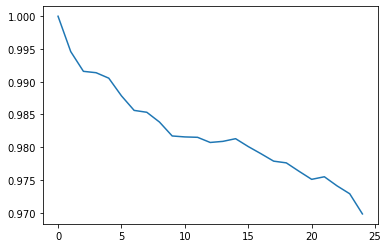

In [0]:
plt.plot(nmf_Precisionsresult)

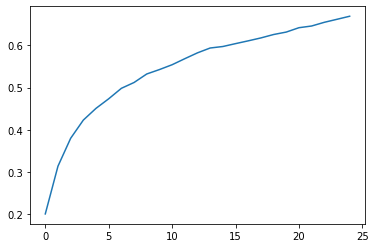

In [0]:
plt.plot(nmf_Recallresult)

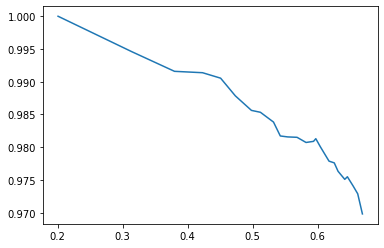

In [0]:
plt.plot(nmf_Recallresult,nmf_Precisionsresult)

In [0]:
svd = SVD(n_factors=14)
svd_averagePrecisions=[]
svd_averageRecalls=[]
data = Dataset.load_from_file(filename,reader=reader)
for trainset, testset in kf.split(data):
    svd.fit(trainset)
    predictions = svd.test(testset)
    recommendlist={}
    for prediction in predictions:
      if recommendlist.get(prediction[0]) is None:
        recommendlist[prediction[0]] = []
      recommendlist[prediction[0]].append((prediction[1], prediction[2]))
    groudtruth={}
    ratelist={}
    for data in testset:
      if ratelist.get(data[0]) is None:
        ratelist[data[0]] = []
      ratelist[data[0]].append(data[1])
      if groudtruth.get(data[0]) is None and data[2]>=threshold:
        groudtruth[data[0]] = [] 
      if data[2]>=threshold:
        groudtruth[data[0]].append(data[1])
    for key in recommendlist:
      recommendlist[key] = sorted(recommendlist[key], key = lambda x:x[1], reverse=True)
      #print(recommendlist[key])
    for t in range(1,26):
      Precision=0
      Recall=0
      sum=0
      for key in ratelist:        
        if len(ratelist[key])>t and groudtruth.get(key) and len(groudtruth[key])>0:
          sum+=1
          #list = recommendlist[key]
          intersection=0
          for r in recommendlist[key][0:t]:
            if r[0] in groudtruth[key]:
              intersection+=1
          Precision+=intersection/len(recommendlist[key][0:t])
          Recall+=intersection/len(groudtruth[key])
      Precision=Precision/sum
      Recall=Recall/sum
      svd_averagePrecisions.append(Precision)
      svd_averageRecalls.append(Recall)
      print(svd_averagePrecisions,svd_averageRecalls)

[1.0] [0.19890339258899922]
[1.0, 0.9933206106870229] [0.19890339258899922, 0.312889797673861]
[1.0, 0.9933206106870229, 0.9964387464387465] [0.19890339258899922, 0.312889797673861, 0.3801952584864406]
[1.0, 0.9933206106870229, 0.9964387464387465, 0.9957729468599034] [0.19890339258899922, 0.312889797673861, 0.3801952584864406, 0.4240946247074224]
[1.0, 0.9933206106870229, 0.9964387464387465, 0.9957729468599034, 0.9919571045576412] [0.19890339258899922, 0.312889797673861, 0.3801952584864406, 0.4240946247074224, 0.45769160398415737]
[1.0, 0.9933206106870229, 0.9964387464387465, 0.9957729468599034, 0.9919571045576412, 0.9882697947214076] [0.19890339258899922, 0.312889797673861, 0.3801952584864406, 0.4240946247074224, 0.45769160398415737, 0.4893336127369755]
[1.0, 0.9933206106870229, 0.9964387464387465, 0.9957729468599034, 0.9919571045576412, 0.9882697947214076, 0.9879013494648674] [0.19890339258899922, 0.312889797673861, 0.3801952584864406, 0.4240946247074224, 0.45769160398415737, 0.48933

In [0]:
svd_Precisionsresult=[]
svd_Recallresult=[]
for t in range(25):
  Precision=0
  Recall=0
  for i in range(10):
    Precision+=svd_averagePrecisions[t+25*i]
    Recall+=svd_averageRecalls[t+25*i]
  svd_Precisionsresult.append(Precision/10)
  svd_Recallresult.append(Recall/10)

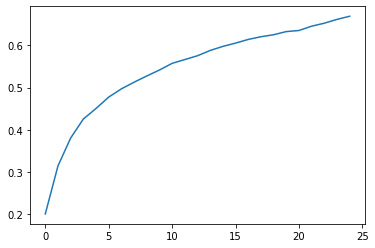

In [0]:
plt.plot(svd_Recallresult)

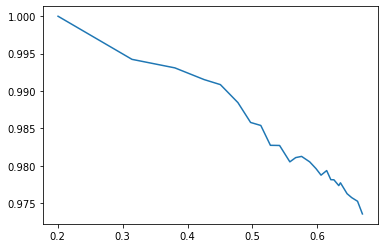

In [0]:
plt.plot(svd_Recallresult,svd_Precisionsresult)

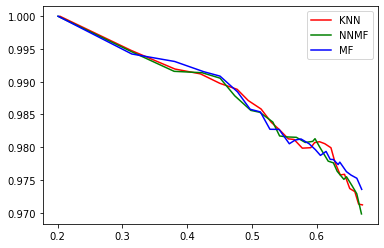

In [0]:
plt.plot(Recallresult, Precisionsresult, 'r', label="KNN")
plt.plot(nmf_Recallresult, nmf_Precisionsresult, 'g', label="NNMF")
plt.plot(svd_Recallresult, svd_Precisionsresult, 'b', label="MF")
plt.legend()
plt.show()